In [1]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Parameters

In [4]:
input_size = 784
num_classes = 10
num_epochs = 40
batch_size = 512
learning_rate = 0.001

### MNIST dataset 

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

In [7]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=transform)

In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Fully connected neural network

In [11]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        #layers
        self.l1 = nn.Linear(784, 256) # layer 1
        self.l2 = nn.Linear(256, 128) # layer 2
        self.l3 = nn.Linear(128, 64) # layer 3
        self.l4 = nn.Linear(64, 10) # layer 4
        
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1) 
     
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.sigmoid(x)
        x = self.l4(x)
        x = self.softmax(x)
        return x

In [12]:
model = NeuralNet().to(device)

In [18]:
model2 = NeuralNet().to(device)

In [19]:
models = {"customModel1": model, "CustomModel2":model2 }

### Loss and optimizer

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train the model

In [14]:
epochs_arr=[]
losses_arr=[]
epochs_loss=0

In [15]:
size = len(train_loader.dataset)
print(size)

for epoch in range(num_epochs):
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
#         images = images.reshape(-1, 28*28).to(device)
        images = images.view(images.shape[0], -1).to(device)

        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate epochs_loss
        epochs_loss = epochs_loss + loss.item()
        optimizer.step()
        
        if (i+1) % int(size/batch_size) == 0:
            print(loss.item())
            losses_arr.append(loss.item())


60000
0.6016249060630798
0.3250282406806946


KeyboardInterrupt: 

### Loss function vs Epoch

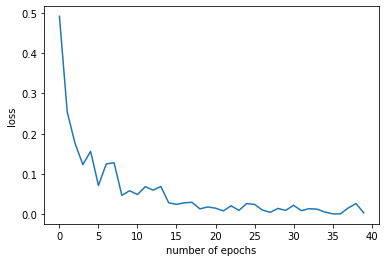

<Figure size 432x288 with 0 Axes>

In [161]:
epochs_arr = list(range(num_epochs))

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('loss')
ax1.set_xlabel('number of epochs')


plt.plot(epochs_arr, losses_arr)
plt.show()
plt.savefig('./plots/custom_arch1_loss.png')

### Test the model

In [162]:
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'cutom_arch.ckpt')

Accuracy of the network on the 10000 test images: 98.04 %


### Building confusion matrix

In [163]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [164]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size =10000)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9804
accuracy 0.9804


True

In [165]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)
stacked[9].tolist()
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1
    
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [166]:
lb = test_dataset.targets.detach().cpu().numpy()

In [167]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [168]:
cm = confusion_matrix(lb, rp)

Confusion matrix, without normalization
[[ 968    0    1    2    1    0    4    0    2    2]
 [   0 1123    0    4    0    2    2    0    4    0]
 [   4    0 1003   11    4    0    1    3    5    1]
 [   1    0    2 1001    0    2    0    1    2    1]
 [   2    0    2    1  957    0    5    2    0   13]
 [   2    0    0    9    1  870    4    0    3    3]
 [   5    1    0    0    2    2  946    0    2    0]
 [   0    2   10    5    1    0    0  996    2   12]
 [   2    0    2    6    0    2    2    2  957    1]
 [   1    1    0    7    5    4    3    1    4  983]]


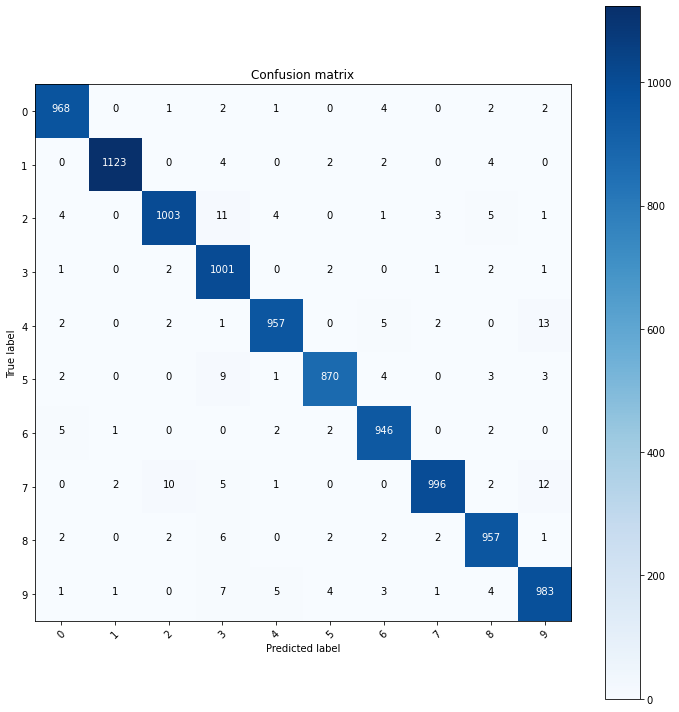

In [169]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)